In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def func(arr):
    x = arr[0]
    y = arr[1]
    return 100*(y-x**2)**2 + (1-x)**2

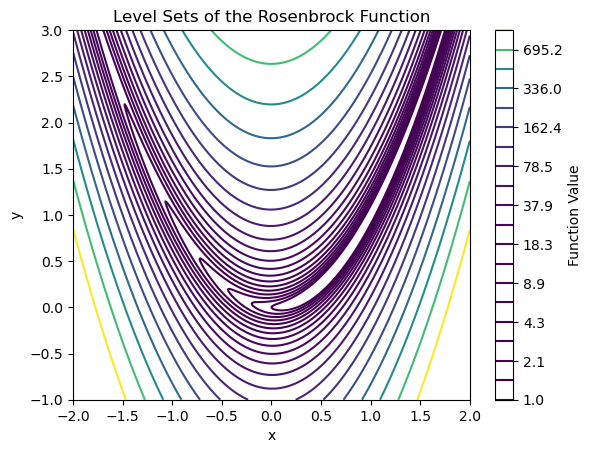

In [14]:
xgrids = np.linspace(-2, 2, 400)
ygrids = np.linspace(-1, 3, 400)
X, Y = np.meshgrid(xgrids, ygrids)

# Calculate the function values for each (x, y) pair
Z = func([X, Y])

# Create a contour plot
plt.figure()
contour = plt.contour(X, Y, Z, levels=np.logspace(0, 3, 20), cmap='viridis')
plt.colorbar(contour, label='Function Value')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Level Sets of the Rosenbrock Function')
plt.show()

In [16]:
def gradf(arr):
    x = arr[0]
    y = arr[1]
    dx = -400*x*(y-x**2) - 2*(1-x)
    dy = 200*(y-x**2)
    res = np.array([dx, dy])
    
    return res

In [17]:
def hessianf(arr):
    x = arr[0]
    y = arr[1]
    res = np.zeros((2, 2))
    dxx = 800*x**2 - 400*(y-x**2) + 2
    dxy = -400*x
    dyy = 200
    res[0, 0] = dxx
    res[0, 1] = dxy
    res[1, 0] = dxy
    res[1, 1] = dyy
    
    return res

In [49]:
# solution
xstar = 1
ystar = 1
pointstar = [xstar, ystar]

In [50]:
print("Gradient value:")
gradf(pointstar)

Gradient value:


array([0, 0])

In [51]:
print("Hessian is SPD or not:")
np.all(np.linalg.eigvals(hessianf(pointstar)) > 0)

Hessian is SPD or not:


True

In [220]:
# initial condition
x = -1.2
y = 1
point = np.array([x, y])

# set configurations
tol = 1e-6 # stop iterations when ||grad f|| < tol
iter_max = 1000 # the maximal number of iterations
draw_flag = 1 # if draw_flag = 1, draw configuration at every iteration

# parameters for backtracking line search
c = 0.5;
rho = 0.9;

In [221]:
# start minimization
# choose algorithm
# direction = 0: steepest descent
# direction = 1: Newton
# direction = 2: BFGS
# direction = 3: FRCG
# direction = 4: PRCG
direction = 4


f = func(point)
g = gradf(point)
norm_g = np.linalg.norm(g)
print("Initially, f = ",f,", ||grad f|| = ",norm_g)

fvals = np.zeros(iter_max)
fvals[0] = f
ngvals = np.zeros(iter_max)
ngvals[0] = norm_g
diffvals = np.zeros(iter_max)
diffvals[0] = np.linalg.norm(point - pointstar)

iter = 1

# new variables
d = len(point)
x_arr = []
g_arr = []
p_arr = []
x_arr.append(point)
g_arr.append(g)
B = np.eye(d)
found_spd = False

while (norm_g > tol and iter < iter_max): 
    #choose search direction
    if( direction == 0): # steepest descent
        p = -g
        dir = "SD"
    
    elif( direction == 1): # Newton
        H = hessianf(point)
#         print(np.linalg.eigvals(H))
        spd = np.all(np.linalg.eigvals(H) > 0)
        if( spd ): # H is SPD, use Newton's direction
            p = np.linalg.solve(H,-g) 
            dir = "Newton"
        else: # use the steepest descent direction
            p = -g
            dir = "SD";
    
    elif (direction == 2): # BFGS
        # initial Hessian
        if found_spd==False:
            B = np.eye(d)
            p = np.linalg.solve(B,-g) 
            found_spd = True
            dir = "BFGS (initialize)"
            
        # update Hessian
        else:
            # reset B matrix
            if iter%20 == 0:
                B = np.eye(d)
            
            y = g_arr[-1] - g_arr[-2]
            y = np.array([y])
            s = np.array(x_arr[-1] - x_arr[-2])
            y = np.reshape(y,(d,1))
            s = np.reshape(s,(d,1))
            
            r = 1/(y.T@s)
            rterm = r*(y@y.T)
            l = 1/(s.T@B@s)
            lterm = l*(B@s@s.T@B)
            
            B = B - lterm + rterm
            p = np.linalg.solve(B,-g) 
            dir = "BFGS"
    
    elif (direction == 3): # FRCG
        if (len(x_arr) == 1): # steepest descent
            p = -g
            dir = "SD"
        
        else:
            gkplus1 = g_arr[-1]
            gk = g_arr[-2]
            numerator = gkplus1.T@gkplus1
            denominator = gk.T@gk
            beta = numerator / denominator
            p = beta*p - gkplus1
            dir = "FRCG"
            
    elif (direction == 4): # PRCG
        if (len(x_arr) == 1): # steepest descent
            p = -g
            dir = "SD"
        
        else:
            gkplus1 = g_arr[-1]
            gk = g_arr[-2]
            numerator = gkplus1.T@(gkplus1 - gk)
            denominator = gk.T@gk
            beta = max(numerator / denominator, 0)
            p = beta*p - gkplus1
            dir = "PRCG"
    
    else:
        print("direction is out of range")
        break
        
    # normalize the search direction if its length greater than 1
    norm_p = np.linalg.norm(p)
    if( norm_p > 1):
        p = p/norm_p
        
    # do backtracking line search along the direction p
    a = 1 # initial step length
    f_temp = func(point + a*p)
    cpg = c*np.dot(p,g)
#     print("cpg = ",cpg,"f = ",f,"f_temp = ",f_temp)

    while( f_temp > f + a*cpg ): # check Wolfe's condition 1
        a = a*rho
        if( a < 1e-14 ):
            print("line search failed\n");
            iter = iter_max-1
            break
        f_temp = func(point + a*p)        
#         print("f_temp = ",f_temp)

    point = point + a*p
    f = func(point)
    g = gradf(point)
    
    # new added
    x_arr.append(point)
    g_arr.append(g)
    p_arr.append(a*p)
    
    norm_g = np.linalg.norm(g)
#     print("iter ",iter,": dir = ",dir,", f = ",f,", ||grad f|| = ",norm_g,", step length = ",a)
    print(f"iter {iter}: dir = {dir}, f = {f:.6f}, ||grad f|| = {norm_g:.6e}, step length = {a:.3e}")

    fvals[iter] = f
    ngvals[iter] = norm_g
    diffvals[iter] = np.linalg.norm(point - pointstar)
    iter = iter + 1
print(f"Result: f = {f:.10f}, ||grad f|| = {norm_g:.6e}")
    

Initially, f =  24.199999999999996 , ||grad f|| =  232.86768775422664
iter 1: dir = SD, f = 4.275938, ||grad f|| = 1.780046e+01, step length = 1.668e-01
iter 2: dir = PRCG, f = 4.126976, ||grad f|| = 1.792591e+00, step length = 1.642e-02
iter 3: dir = PRCG, f = 2.218807, ||grad f|| = 5.719294e+00, step length = 1.000e+00
iter 4: dir = PRCG, f = 2.124523, ||grad f|| = 3.520876e+00, step length = 3.815e-02
iter 5: dir = PRCG, f = 0.316961, ||grad f|| = 1.602215e+00, step length = 9.000e-01
iter 6: dir = PRCG, f = 0.311133, ||grad f|| = 1.026293e+00, step length = 7.070e-03
iter 7: dir = PRCG, f = 0.290219, ||grad f|| = 3.183118e+00, step length = 4.239e-02
iter 8: dir = PRCG, f = 0.200418, ||grad f|| = 6.254459e+00, step length = 1.853e-01
iter 9: dir = PRCG, f = 0.158837, ||grad f|| = 5.220043e-01, step length = 1.330e-02
iter 10: dir = PRCG, f = 0.153469, ||grad f|| = 2.135557e+00, step length = 3.815e-02
iter 11: dir = PRCG, f = 0.094427, ||grad f|| = 4.820735e+00, step length = 1.853

Text(0.5, 1.0, '$||(x_{k}, y_{k}) - (x^{*}, y^{*}) ||$ versus k in logarithmic scale')

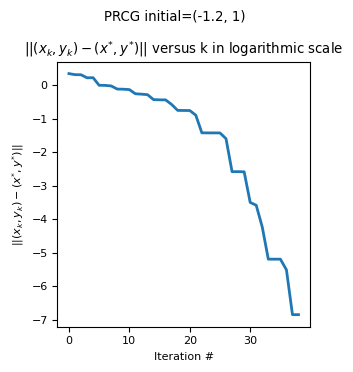

In [222]:
fig, (ax1) = plt.subplots(1, 1, figsize=(4,4))
fig.tight_layout(pad=5)
plt.rcParams.update({'font.size': 8})
plt.suptitle("PRCG initial=(-1.2, 1)")
# ax1.figure(figsize=(8,8))
ax1.plot(np.arange(iter),np.log10(diffvals[0:iter]),linewidth = 2)
ax1.set_xlabel("Iteration #")
ax1.set_ylabel(r'$||(x_{k}, y_{k}) - (x^{*}, y^{*}) ||$')
ax1.set_title(r'$||(x_{k}, y_{k}) - (x^{*}, y^{*}) ||$ versus k in logarithmic scale')

In [223]:
p_arr.append(np.array([0, 0]))
p_arr

[array([0.15440529, 0.06302257]),
 array([0.0154458 , 0.00558111]),
 array([ 0.56472905, -0.82527638]),
 array([ 0.00816021, -0.03726915]),
 array([ 0.89981824, -0.01808673]),
 array([-0.00032583,  0.00706214]),
 array([0.03693623, 0.02080205]),
 array([0.12932125, 0.13271342]),
 array([-0.00634997,  0.01168941]),
 array([0.00890646, 0.01781301]),
 array([0.11985126, 0.14132414]),
 array([0.00176805, 0.01632776]),
 array([0.01247806, 0.01338029]),
 array([0.08326719, 0.12487984]),
 array([-0.00230915,  0.00750809]),
 array([0.00020591, 0.00152892]),
 array([0.05290169, 0.08247288]),
 array([0.04365886, 0.07713022]),
 array([-0.00339739,  0.00242584]),
 array([0.00015856, 0.00085749]),
 array([0.0240482, 0.0412443]),
 array([0.04086036, 0.07864857]),
 array([-0.00121846,  0.00079628]),
 array([-9.65826910e-05,  6.53103094e-05]),
 array([-2.26232621e-06,  7.23807189e-05]),
 array([0.00578927, 0.01068683]),
 array([0.00983222, 0.02026959]),
 array([-3.98741307e-06,  3.10267040e-06]),
 arr

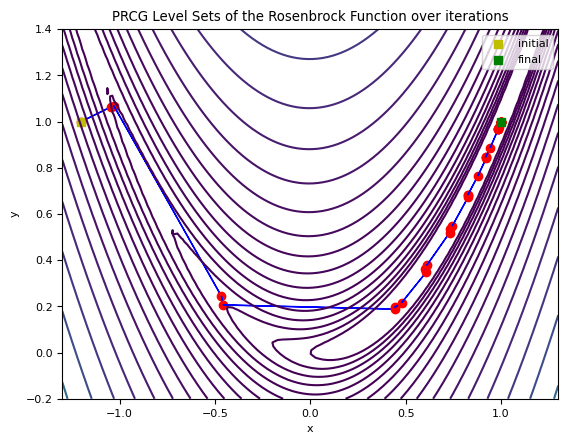

In [224]:
xgrids = np.linspace(-1.3, 1.3, 100)
ygrids = np.linspace(-0.2, 1.4, 100)
X, Y = np.meshgrid(xgrids, ygrids)

# Calculate the function values for each (x, y) pair
Z = func([X, Y])

# Create a contour plot
plt.figure()
contour = plt.contour(X, Y, Z, levels=np.logspace(0, 3, 20), cmap='viridis')
# plt.colorbar(contour, label='Function Value')
plt.xlabel('x')
plt.ylabel('y')
plt.title('PRCG Level Sets of the Rosenbrock Function over iterations')

# drawing the steps on contour map
for point, p in zip(x_arr[0:iter], p_arr[0:iter]):
    plt.scatter(point[0], point[1], color='red', marker='o') #, label=f'Iteration {iteration + 1}'
    plt.arrow(point[0], point[1], p[0], p[1], head_width=0.008, head_length=0.008, 
              length_includes_head=True, fc='blue', ec='blue')

plt.scatter(x_arr[0][0], x_arr[0][1], color='y', marker=',', label=f'initial')
plt.scatter(x_arr[-1][0], x_arr[-1][1], color='g', marker=',', label=f'final')
plt.legend()
    
plt.show()